In [17]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

In [3]:
env = gym2.make('Linear-v1')

In [4]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [20]:
alpha = 0.1
beta = 0.5

# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0.):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1

def value_function(actor, n_episodes=5, init_state=np.array([1,2])):
    average_reward = 0
    for _ in range(n_episodes):
        x = init_state
        episode_time = 0
        episode_reward = 0
        log = []
        while True:
            a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
            log.append([x, episode_time])
            reward, x = interaction(x, a_agent, tau, env, ln=1.)
            episode_reward += np.exp(- alpha * episode_time) * reward
            episode_time += tau
            if episode_time >= 30.:
                log.append([x, episode_time])
                break
        average_reward += episode_reward
    return average_reward / n_episodes

def evaluation_function(actor):
    s1 = np.linspace(-7, 7, 20)
    s2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(s1, s2)
    S1, S2 = S1.flatten(), S2.flatten()
    average_value = 0
    for i, x in enumerate(zip(S1, S2)):
        x = np.array(x)
        average_value += value_function(actor, init_state=x)
    return average_value / len(S1)

def evaluation_function_parallel(actor):
    s1 = np.linspace(-7, 7, 20)
    s2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(s1, s2)
    S1, S2 = S1.flatten(), S2.flatten()

    average_value = np.mean(Parallel(n_jobs=-1)( [delayed(value_function)(actor, init_state=np.array(x)) for x in zip(S1, S2)] ))
    return average_value

In [21]:
actor = branch_actor((2,),(2,))

## $\pi_{prop}$ 

In [25]:
# policy
actor.load_weights('../saved_agent/learned_self_linear_proposed5_actor.h5')

In [28]:
%%time
evs1 = []
for i in range(50):
    evs1.append(evaluation_function_parallel(actor))
    print(f'{int(i * 50 / 100)}%\r',end='')

CPU times: user 4min 36s, sys: 25.9 s, total: 5min 2s
Wall time: 1h 6min 14s


-9.891537372588893 0.0011232027256626695


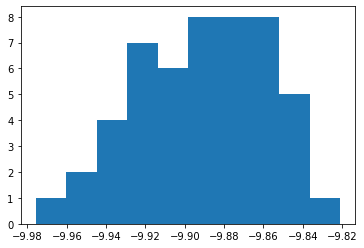

In [35]:
print(np.mean(evs1), np.var(evs1))
plt.hist(evs1)
plt.show()

## $\pi_{MB}$ 

In [29]:
# policy
actor.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')

In [30]:
%%time
evs2 = []
for i in range(50):
    evs2.append(evaluation_function_parallel(actor))
    print(f'{int(i * 50 / 100)}%\r',end='')

CPU times: user 4min 39s, sys: 25.8 s, total: 5min 5s
Wall time: 1h 14min 50s


-14.827416315879807 0.00046594779825368643


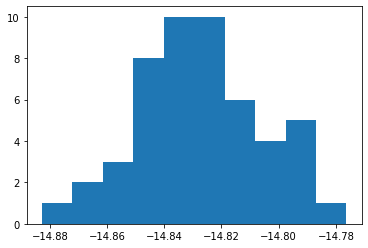

In [34]:
print(np.mean(evs2), np.var(evs2))
plt.hist(evs2)
plt.show()

In [ ]:
with open('../csv/ev_proposed5')